Importing all the dependencies

In [35]:
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
import torch
import os
import pandas as pd
import torchvision.models
from torchvision.models import MobileNet_V3_Large_Weights
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory

Creating a dataset and checking that it is properly reading the file

In [13]:
annotations = pd.read_csv('../BoundingBoxPairs/Annotations/annotations.csv')

test_index = 1
image_name = annotations.iloc[test_index, 0]
labels = annotations.iloc[test_index, 1:]
labels = np.array(labels, dtype=float).reshape(-1, 4)

print('Image name: {}'.format(image_name))
print('Label shape: {}'.format(labels.shape))
print('First Few Labels: {}'.format(labels[:4]))

class SDDTrainingData(Dataset):
    def __init__(self, csv_file, images_root, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.images_root = images_root
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, item):
        img_name = os.path.join(self.images_root, self.annotations.iloc[item, 0])
        image = read_image(img_name)

        boxes = self.annotations.iloc[item, 1:]
        boxes = np.array([boxes], dtype=int).reshape(-1, 4)
        sample = {'image': image, 'annotations': boxes}

        if self.transform:
            sample = self.transform(sample)

        return sample


Image name: 100_blur.png
Label shape: (50, 4)
First Few Labels: [[  7. 261.  82.  72.]
 [  6. 262.  84.  71.]
 [102. 176. 135. 110.]
 [101. 176. 137. 109.]]


[[  7. 261.  82.  72.]
 [  6. 262.  84.  71.]
 [102. 176. 135. 110.]
 [101. 176. 137. 109.]
 [146.  12. 385. 468.]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]
 [ nan  nan

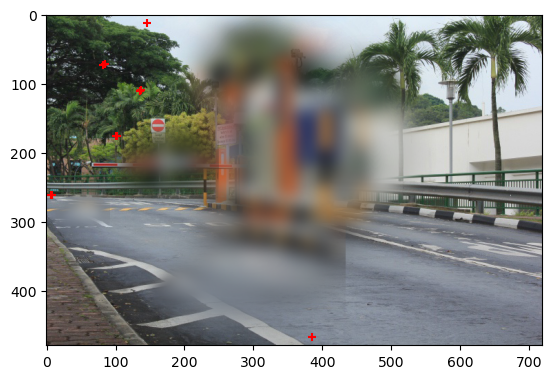

In [33]:
plt.ion()

def show_annotation(image, annots):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.scatter(np.append(annots[:, 0], annots[:, 2], 0), np.append(annots[:, 1], annots[:, 3], 0), s=30, marker='+', c='r')
    plt.pause(0.001)
    
plt.figure()
print(labels)

show_annotation(cv.imread(os.path.join("../BoundingBoxPairs/output/", image_name)), labels)
#Image ends up inverted for some reason, but the effect is the same
plt.show()

Creating the dataloader

In [ ]:
train_dataset = SDDTrainingData('../BoundingBoxPairs/Annotations/annotations.csv', '../BoundingBoxPairs/output/', transform=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1.transforms)

val_dataset = SDDTrainingData('../BoundingBoxPairs/validation_set/val_annotations/val_annotations.csv', '../BoundingBoxPairs/validation_set/val_output')

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

Loading the SDDLite Model since it is made for image segmentation
It has 2 classes: Background and RainDrop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

sdd_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
    weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT,
    weights_backbone=MobileNet_V3_Large_Weights,
    progress=True,
    num_classes=2)



Training the model to identify the distortions

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    phases = ['train', 'val']
    with TemporaryDirectory as tempdir:
        best_model_params = os.path.join(tempdir, 'best_params')
        
        torch.save(model.state_dict(), best_model_params)
        
        for epoch in range(num_epochs):
            print(f'Epoch: {epoch}/{num_epochs - 1}')
            
            for phase in phases:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                

Creating the parameters for the model training